https://www.kaggle.com/competitions/ieee-fraud-detection

# Sobre os Dados

## Tabela Transação

* `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

* `TransactionAMT`: transaction payment amount in USD

* `ProductCD`: product code, the product for each transaction

* `card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

* `addr`: address

* `dist`: distance

* `P_ and (R__) emaildomain`: purchaser and recipient email domain

* `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

* `D1-D15`: timedelta, such as days between previous transaction, etc.

* `M1-M9`: match, such as names on card and address, etc.

* `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features

* `ProductCD`

* `card1 - card6`

* `addr1, addr2`

* `P_emaildomain`

* `R_emaildomain`

* `M1 - M9`

## Tabela Identidade

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

### Categorical Features

* `DeviceType`

* `DeviceInfo`

* `id_12 - id_38`

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.170000000000002
1,isFraud,int64,0,2,0,0,0,0.220000000000000
2,TransactionDT,int64,0,573349,86400,86401,86469,19.109999999999999
3,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
4,ProductCD,object,0,5,W,W,W,1.280000000000000
5,card1,int64,0,13553,13926,2755,4663,9.970000000000001
6,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
7,card3,float64,1565,114,150.0,150.0,150.0,0.680000000000000
8,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
9,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000


In [10]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,506691,3663549,3663550,3663551,18.949999999999999
1,TransactionDT,int64,0,494686,18403224,18403263,18403310,18.899999999999999
2,TransactionAmt,float64,0,14119,31.949999999999999,49.0,171.0,8.080000000000000
3,ProductCD,object,0,5,W,W,W,1.370000000000000
4,card1,int64,0,13244,10409,4272,4476,9.949999999999999
5,card2,float64,8654,497,111.0,111.0,574.0,6.280000000000000
6,card3,float64,3002,115,150.0,150.0,150.0,0.810000000000000
7,card4,object,3086,4,visa,visa,visa,1.050000000000000
8,card5,float64,4547,102,226.0,226.0,226.0,2.630000000000000
9,card6,object,3007,3,debit,debit,debit,0.790000000000000


In [11]:
# checando todas as colunas dos conjuntos de dado de treino e teste
for i in list(train):
    print("'" + i + "'" + ", ")

'TransactionID', 
'isFraud', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V6

In [12]:
for i in list(test):
    print("'" + i + "'" + ", ")

'TransactionID', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V65', 
'V66', 

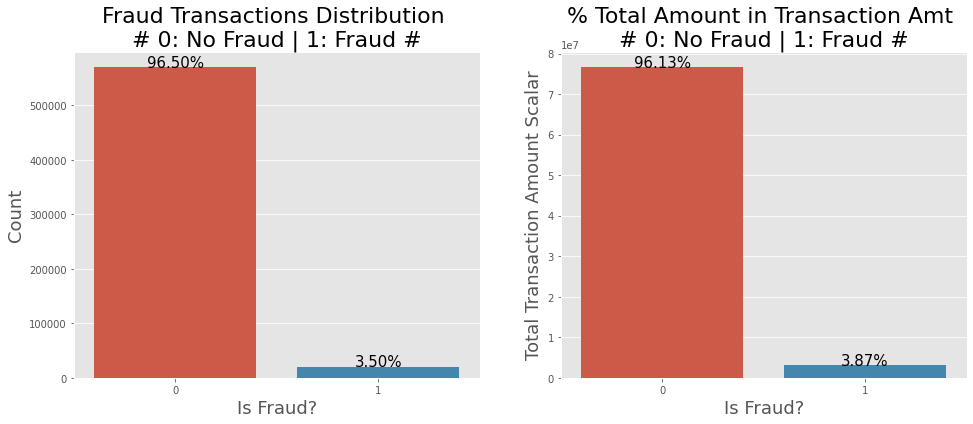

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [17]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [18]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [19]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [20]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [21]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

V328: 86.05496664070174%
V329: 86.05496664070174%
V330: 86.05496664070174%
V331: 86.05496664070174%
V332: 86.05496664070174%
V333: 86.05496664070174%
V334: 86.05496664070174%
V335: 86.05496664070174%
V336: 86.05496664070174%
V337: 86.05496664070174%
V338: 86.05496664070174%
V339: 86.05496664070174%
id_01: 75.5760829071697%
id_02: 76.14522301622245%
id_03: 88.76892335828225%
id_04: 88.76892335828225%
id_05: 76.82375452975243%
id_06: 76.82375452975243%
id_07: 99.12707013919463%
id_08: 99.12707013919463%
id_09: 87.31229044603245%
id_10: 87.31229044603245%
id_11: 76.12727334304196%
id_12: 75.5760829071697%
id_13: 78.44007179869273%
id_14: 86.4456260371863%
id_15: 76.12608798726589%
id_16: 78.09801198902699%
id_17: 76.39973583499848%
id_18: 92.36072069631184%
id_19: 76.40837199850984%
id_20: 76.41802418125783%
id_21: 99.12639279303689%
id_22: 99.1246994276425%
id_23: 99.1246994276425%
id_24: 99.19615944728554%
id_25: 99.13096487960172%
id_26: 99.12571544687913%
id_27: 99.1246994276425%
id_2

In [22]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [23]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [24]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [25]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [26]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [27]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [28]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [29]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [30]:
train.shape

(590540, 92)

In [31]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [32]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [33]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [34]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [35]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,isFraud,int64,0,2,0,0,0,0.220000000000000
1,TransactionAmt,float64,0,20902,68.5,29.0,59.0,8.350000000000000
2,ProductCD,object,0,5,W,W,W,1.280000000000000
3,card1,int64,0,13553,13926,2755,4663,9.970000000000001
4,card2,float64,8933,500,NaN,404.0,490.0,6.320000000000000
5,card4,object,1577,4,discover,mastercard,visa,1.090000000000000
6,card5,float64,4259,119,142.0,102.0,166.0,2.660000000000000
7,addr1,float64,65706,332,315.0,325.0,330.0,5.060000000000000
8,dist1,float64,352271,2651,19.0,NaN,287.0,6.340000000000000
9,P_emaildomain,object,94456,59,NaN,gmail.com,outlook.com,2.680000000000000


In [36]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [37]:
train = replace_missing_values(train)

In [38]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [39]:
test = replace_missing_values(test)

In [40]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [41]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [42]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [43]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [44]:
# realizando a transformação usando LabelEncoder
#le = LabelEncoder()
#for col in object_columns_treated:
#    if col in train.columns:
#        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#        train[col] = le.fit_transform(list(train[col].astype(str).values))
#        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [45]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


,Name,dtypes


In [46]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


,Name,dtypes


In [47]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [48]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [49]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [50]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [51]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [52]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [53]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [54]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML

In [55]:
# separando a coluna target
X = train.drop('isFraud',axis = 1)
y = train['isFraud'].astype('uint8')

In [56]:
y.value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

In [57]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [58]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
isFraud
0    113975
1      4133
Name: count, dtype: int64


# Balanceamento de Classes

## Undersample

### Undersampling com Near Miss

In [59]:
from imblearn.under_sampling import NearMiss

In [60]:
nm = NearMiss()

In [61]:
%%time
X_train_undersample_with_near_miss, y_train_undersample_with_near_miss = nm.fit_resample(X_train, y_train)
X_test_undersample_with_near_miss, y_test_undersample_with_near_miss = nm.fit_resample(X_test, y_test)

CPU times: user 2min 8s, sys: 823 ms, total: 2min 9s
Wall time: 11.9 s


In [62]:
# combinando as classes minoritária com a majoritária subamostrada
train_undersample_with_near_miss = pd.concat([X_train_undersample_with_near_miss, y_train_undersample_with_near_miss], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_undersample_with_near_miss.isFraud.value_counts()

isFraud
0    16530
1    16530
Name: count, dtype: int64

In [63]:
# combinando as classes minoritária com a majoritária subamostrada
test_undersample_with_near_miss = pd.concat([X_test_undersample_with_near_miss, y_test_undersample_with_near_miss], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_undersample_with_near_miss.isFraud.value_counts()

isFraud
0    4133
1    4133
Name: count, dtype: int64

## Oversample

### Resample

In [64]:
from sklearn.utils import resample

In [65]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify = train.isFraud)

In [66]:
%%time
train_split_not_fraud = train_split[train_split.isFraud == 0]
train_split_fraud = train_split[train_split.isFraud == 1]

test_split_not_fraud = test_split[test_split.isFraud == 0]
test_split_fraud = test_split[test_split.isFraud == 1]

CPU times: user 109 ms, sys: 27.8 ms, total: 137 ms
Wall time: 136 ms


In [67]:
%%time
train_split_fraud_upsampled = resample(train_split_fraud, 
                           replace = True, # sample with replacement
                           n_samples = len(train_split_not_fraud), # match number in majority class
                           random_state = 27)

CPU times: user 72.4 ms, sys: 23.6 ms, total: 96 ms
Wall time: 94.9 ms


In [68]:
%%time
test_split_fraud_upsampled = resample(test_split_fraud, 
                           replace = True, # sample with replacement
                           n_samples = len(test_split_not_fraud), # match number in majority class
                           random_state = 27)

CPU times: user 16.5 ms, sys: 8.01 ms, total: 24.5 ms
Wall time: 23.7 ms


In [69]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_resample = pd.concat([train_split_not_fraud, train_split_fraud_upsampled])

# contando as classes minoritária e majoritária
train_oversample_with_resample.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

In [70]:
# combinando as classes majoritária com a minoritária sobreamostrada 
test_oversample_with_resample = pd.concat([test_split_not_fraud, test_split_fraud_upsampled])

# contando as classes minoritária e majoritária
test_oversample_with_resample.isFraud.value_counts()

isFraud
0    113975
1    113975
Name: count, dtype: int64

In [71]:
X_train_oversample_with_resample = train_oversample_with_resample.drop('isFraud',axis = 1)
y_train_oversample_with_resample = train_oversample_with_resample['isFraud'].astype('uint8')

In [72]:
X_test_oversample_with_resample = test_oversample_with_resample.drop('isFraud',axis = 1)
y_test_oversample_with_resample = test_oversample_with_resample['isFraud'].astype('uint8')

### Random over-sampling

In [73]:
from imblearn.over_sampling import RandomOverSampler

In [74]:
ros = RandomOverSampler(random_state=42)

In [75]:
%%time
X_train_oversample_with_ros, y_train_oversample_with_ros = ros.fit_resample(X_train, y_train)
X_train_oversample_with_ros, y_train_oversample_with_ros = nm.fit_resample(X_train_oversample_with_ros, \
                                                                           y_train_oversample_with_ros)

X_test_oversample_with_ros, y_test_oversample_with_ros = ros.fit_resample(X_test, y_test)
X_test_oversample_with_ros, y_test_oversample_with_ros = nm.fit_resample(X_test_oversample_with_ros\
                                                                         , y_test_oversample_with_ros)

CPU times: user 1h 6min 9s, sys: 1.06 s, total: 1h 6min 10s
Wall time: 5min 38s


In [76]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_ros = pd.concat([X_train_oversample_with_ros, y_train_oversample_with_ros], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_ros.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

In [77]:
# combinando as classes majoritária com a minoritária sobreamostrada 
test_oversample_with_ros = pd.concat([X_test_oversample_with_ros, y_test_oversample_with_ros], axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_oversample_with_ros.isFraud.value_counts()

isFraud
0    113975
1    113975
Name: count, dtype: int64

### Oversampling com SMOTE

In [78]:
from imblearn.over_sampling import SMOTE

In [79]:
smote = SMOTE(random_state=42)

In [80]:
%%time
X_train_oversample_with_smote, y_train_oversample_with_smote = ros.fit_resample(X_train, y_train)
X_train_oversample_with_smote, y_train_oversample_with_smote = nm.fit_resample(X_train_oversample_with_smote, \
                                                                           y_train_oversample_with_smote)

X_test_oversample_with_smote, y_test_oversample_with_smote = ros.fit_resample(X_test, y_test)
X_test_oversample_with_smote, y_test_oversample_with_smote = nm.fit_resample(X_test_oversample_with_smote\
                                                                         , y_test_oversample_with_smote)

CPU times: user 1h 6min 51s, sys: 1.11 s, total: 1h 6min 52s
Wall time: 5min 44s


In [81]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

In [82]:
# combinando as classes majoritária com a minoritária sobreamostrada 
test_oversample_with_smote = pd.concat([X_test_oversample_with_smote, y_test_oversample_with_smote], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_oversample_with_smote.isFraud.value_counts()

isFraud
0    113975
1    113975
Name: count, dtype: int64

### Oversampling com Borderline-SMOTE

In [83]:
from imblearn.over_sampling import BorderlineSMOTE

In [84]:
smote = BorderlineSMOTE(random_state=42)

In [85]:
%%time
X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote = ros.fit_resample(X_train, y_train)
X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote = \
nm.fit_resample(X_train_oversample_with_borderline_smote, \
                                                                           y_train_oversample_with_borderline_smote)

X_test_oversample_with_borderline_smote, y_test_oversample_with_borderline_smote = ros.fit_resample(X_test, y_test)
X_test_oversample_with_borderline_smote, y_test_oversample_with_borderline_smote = \
nm.fit_resample(X_test_oversample_with_borderline_smote\
                                                                         , y_test_oversample_with_borderline_smote)

CPU times: user 1h 6min 46s, sys: 1.02 s, total: 1h 6min 47s
Wall time: 5min 40s


In [86]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_borderline_smote = pd.concat([X_train_oversample_with_borderline_smote, \
                                                    y_train_oversample_with_borderline_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_borderline_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

In [87]:
# combinando as classes majoritária com a minoritária sobreamostrada 
test_oversample_with_borderline_smote = pd.concat([X_test_oversample_with_borderline_smote, \
                                                   y_test_oversample_with_borderline_smote], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_oversample_with_borderline_smote.isFraud.value_counts()

isFraud
0    113975
1    113975
Name: count, dtype: int64

### Oversampling com AdaSyn

In [88]:
from imblearn.over_sampling import ADASYN

In [89]:
adasyn = ADASYN(random_state=42)

In [90]:
%%time
X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = ros.fit_resample(X_train, y_train)
X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = \
nm.fit_resample(X_train_oversample_with_adasyn, \
                                                                           y_train_oversample_with_adasyn)

X_test_oversample_with_adasyn, y_test_oversample_with_adasyn = ros.fit_resample(X_test, y_test)
X_test_oversample_with_adasyn, y_test_oversample_with_adasyn = \
nm.fit_resample(X_test_oversample_with_adasyn\
                                                                         , y_test_oversample_with_adasyn)

CPU times: user 1h 6min 57s, sys: 1.04 s, total: 1h 6min 58s
Wall time: 5min 41s


In [91]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_adasyn.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

In [92]:
# combinando as classes majoritária com a minoritária sobreamostrada 
test_oversample_with_adasyn = pd.concat([X_test_oversample_with_adasyn, \
                                                   y_test_oversample_with_adasyn], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_oversample_with_adasyn.isFraud.value_counts()

isFraud
0    113975
1    113975
Name: count, dtype: int64

In [93]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.5e+03 s


# Redução de Dimensionalidade

## Seleção de Atributos com Teste do Qui-Quadrado

In [94]:
# importando as bibliotecas necessárias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Undersampling com Near Miss

In [95]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_50_chi2 = new_50_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_undersample_with_near_miss.iloc[:, cols]

In [96]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_chi2 = new_100_chi2.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_undersample_with_near_miss.iloc[:, cols]

In [97]:
undersample_with_near_miss_cols_50_chi2 = features_df_new_50_chi2.columns
undersample_with_near_miss_cols_100_chi2 = features_df_new_100_chi2.columns

In [98]:
undersample_with_near_miss_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V12', 'V13', 'V35', 'V36', 'V50', 'V53', 'V54', 'V75',
       'V76', 'V84', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V283', 'V285', 'V307', 'V308', 'V310', 'ProductCD_C', 'ProductCD_W',
       'P_emaildomain_hotmail.com', 'M4_M0', 'M4_M2', 'M5_T', 'M6_T'],
      dtype='object')

In [99]:
undersample_with_near_miss_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Hours', '_Days',
       'ProductCD_C', 'ProductCD_H', 'ProductCD_S', 'ProductCD_W',
       'card4_american express', 'card4_discover', 'card4_mastercard',
       'P_emaildomain_aim.com', 'P_emaildomain_anonymous.com',
       'P_emaildomain_aol.com', 'P_emaildomain_comcast.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_hotmail.es', 'P_emaildomain_live.com.mx',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.es',
       'P_emai

### Oversample com Resample

In [100]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_50_chi2 = new_50_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_resample.iloc[:, cols]

In [101]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_chi2 = new_100_chi2.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_resample.iloc[:, cols]

In [102]:
oversample_with_resample_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_resample_cols_100_chi2 = features_df_new_100_chi2.columns

In [103]:
oversample_with_resample_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [104]:
oversample_with_resample_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V5', 'V10', 'V11', 'V12', 'V13', 'V29',
       'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81',
       'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130',
       'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays',
       '_Hours', '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'P_emaildomain_aim.com',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_emaild

### Random over-sampling

In [105]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_50_chi2 = new_50_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_ros.iloc[:, cols]

In [106]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_chi2 = new_100_chi2.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_ros.iloc[:, cols]

In [107]:
oversample_with_ros_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_ros_cols_100_chi2 = features_df_new_100_chi2.columns

In [108]:
oversample_with_ros_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [109]:
oversample_with_ros_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V3', 'V5', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127',
       'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310',
       '_Weekdays', '_Hours', '_Days', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_S', 'ProductCD_W', 'card4_discover', 'P_emaildomain_aim.com',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_

### Oversampling com SMOTE

In [110]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [111]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [112]:
oversample_with_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [113]:
oversample_with_smote_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [114]:
oversample_with_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V3', 'V5', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127',
       'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310',
       '_Weekdays', '_Hours', '_Days', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_S', 'ProductCD_W', 'card4_discover', 'P_emaildomain_aim.com',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_

### Oversampling com Borderline-SMOTE

In [115]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [116]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [117]:
oversample_with_borderline_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_borderline_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [118]:
oversample_with_borderline_smote_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [119]:
oversample_with_borderline_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V3', 'V5', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127',
       'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310',
       '_Weekdays', '_Hours', '_Days', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_S', 'ProductCD_W', 'card4_discover', 'P_emaildomain_aim.com',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_

### Oversampling com AdaSyn

In [120]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_50_chi2 = new_50_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [121]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_chi2 = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [122]:
oversample_with_adasyn_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_adasyn_cols_100_chi2 = features_df_new_100_chi2.columns

In [123]:
oversample_with_adasyn_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V49', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [124]:
oversample_with_adasyn_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V3', 'V5', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127',
       'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310',
       '_Weekdays', '_Hours', '_Days', 'ProductCD_C', 'ProductCD_H',
       'ProductCD_S', 'ProductCD_W', 'card4_discover', 'P_emaildomain_aim.com',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_mail.com',
       'P_emaildomain_msn.com', 'P_emaildomain_outlook.com',
       'P_emaildomain_outlook.es', 'P_emaildomain_protonmail.com',
       'P_

## Seleção de Features com Teste ANOVA

In [125]:
from sklearn.feature_selection import f_classif

### Undersampling com Near Miss

In [126]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_50_anova = new_50_anova.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_undersample_with_near_miss.iloc[:, cols]

In [127]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_undersample_with_near_miss, y_train_undersample_with_near_miss)
X_train_undersample_with_near_miss_100_anova = new_100_anova.transform(X_train_undersample_with_near_miss)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_undersample_with_near_miss.iloc[:, cols]

In [128]:
undersample_with_near_miss_cols_50_anova = features_df_new_50_anova.columns
undersample_with_near_miss_cols_100_anova = features_df_new_100_anova.columns

In [129]:
undersample_with_near_miss_cols_50_anova

Index(['TransactionAmt', 'D1', 'D2', 'D4', 'D10', 'D15', 'V1', 'V10', 'V11',
       'V12', 'V13', 'V35', 'V36', 'V39', 'V42', 'V43', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V84',
       'V85', 'V92', 'V93', 'V96', 'V99', 'V127', 'V283', 'V285', 'V310',
       'ProductCD_C', 'ProductCD_W', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'M3_F', 'M3_T', 'M4_M0', 'M4_M2', 'M5_F',
       'M5_T', 'M6_F', 'M6_T'],
      dtype='object')

In [130]:
undersample_with_near_miss_cols_100_anova

Index(['TransactionAmt', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V1', 'V3', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V29',
       'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50',
       'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81',
       'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130',
       'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Hours',
       '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_S', 'ProductCD_W',
       'card4_american express', 'card4_discover', 'card4_mastercard',
       'P_emaildomain_anonymous.com', 'P_emaildomain_aol.com',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_yahoo.com',
       'P_emaildomain_yahoo.com.mx', 'M2_F', 'M2_T', 'M3_F', 'M3_T', 'M4_M0',
       'M4_M1', 'M4_M2', 'M5_F', 'M5_T', 'M6_F'

### Oversample com Resample

In [131]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_50_anova = new_50_anova.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_resample.iloc[:, cols]

In [132]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_resample, y_train_oversample_with_resample)
X_train_oversample_with_resample_100_anova = new_100_anova.transform(X_train_oversample_with_resample)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_resample.iloc[:, cols]

In [133]:
oversample_with_resample_cols_50_anova = features_df_new_50_anova.columns
oversample_with_resample_cols_100_anova = features_df_new_100_anova.columns

In [134]:
oversample_with_resample_cols_50_anova

Index(['C5', 'C9', 'D1', 'D2', 'D3', 'D5', 'D10', 'D11', 'D15', 'V10', 'V11',
       'V12', 'V13', 'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V69', 'V70', 'V75', 'V76',
       'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V282', 'V283',
       'ProductCD_C', 'ProductCD_W', 'P_emaildomain_yahoo.com', 'M4_M0',
       'M4_M2', 'M6_F', 'M6_T', 'M8_F', 'M8_T'],
      dtype='object')

In [135]:
oversample_with_resample_cols_100_anova

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15',
       'V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13',
       'V29', 'V30', 'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49',
       'V50', 'V51', 'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80',
       'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V282',
       'V283', 'V285', 'V307', 'V310', '_Weekdays', '_Hours', 'ProductCD_C',
       'ProductCD_H', 'ProductCD_S', 'ProductCD_W', 'card4_discover',
       'P_emaildomain_aim.com', 'P_emaildomain_anonymous.com',
       'P_emaildomain_aol.com', 'P_emaildomain_att.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_mail.com', 'P_emaildomain_msn.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es',
       'P_emaildomain_protonmail.com', 'P_emaildomain_rocketmail.com',
       'P_emai

### Random over-sampling

In [136]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_50_anova = new_50_anova.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_ros.iloc[:, cols]

In [ ]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_ros, y_train_oversample_with_ros)
X_train_oversample_with_ros_100_anova = new_100_anova.transform(X_train_oversample_with_ros)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_ros.iloc[:, cols]

In [ ]:
oversample_with_ros_cols_50_anova = features_df_new_50_anova.columns
oversample_with_ros_cols_100_anova = features_df_new_100_anova.columns

In [ ]:
oversample_with_ros_cols_50_anova

In [ ]:
oversample_with_ros_cols_100_anova

### Oversampling com SMOTE

In [ ]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_50_anova = new_50_anova.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_smote.iloc[:, cols]

In [ ]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_anova = new_100_anova.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_smote.iloc[:, cols]

In [ ]:
oversample_with_smote_cols_50_anova = features_df_new_50_anova.columns
oversample_with_smote_cols_100_anova = features_df_new_100_anova.columns

In [ ]:
oversample_with_smote_cols_50_anova

In [ ]:
oversample_with_smote_cols_100_anova

### Oversampling com Borderline-SMOTE

In [ ]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_50_anova = new_50_anova.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [ ]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_anova = new_100_anova.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [ ]:
oversample_with_borderline_smote_cols_50_anova = features_df_new_50_anova.columns
oversample_with_borderline_smote_cols_100_anova = features_df_new_100_anova.columns

In [ ]:
oversample_with_borderline_smote_cols_50_anova

In [ ]:
oversample_with_borderline_smote_cols_100_anova

### Oversampling com AdaSyn

In [ ]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_50_anova = SelectKBest(score_func = f_classif, k = 50)
new_50_anova = model_50_anova.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_50_anova = new_50_anova.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_50_anova.get_support(indices = True)
features_df_new_50_anova = X_train_oversample_with_adasyn.iloc[:, cols]

In [ ]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train')
model_100_anova = SelectKBest(score_func = f_classif, k = 100)
new_100_anova = model_100_anova.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_anova = new_100_anova.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_anova.get_support(indices = True)
features_df_new_100_anova = X_train_oversample_with_adasyn.iloc[:, cols]

In [ ]:
oversample_with_adasyn_cols_50_anova = features_df_new_50_anova.columns
oversample_with_adasyn_cols_100_anova = features_df_new_100_anova.columns

In [ ]:
oversample_with_adasyn_cols_50_anova

In [ ]:
oversample_with_adasyn_cols_100_anova

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
#from xgboost import XGBClassifier
#import lightgbm as lgbm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_lr = LogisticRegression(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_gnb = GaussianNB()

## Validação Cruzada para Undersampling com Near Miss

### 50-Chi Square

In [ ]:
%%time

clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
           y_train_undersample_with_near_miss)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

### 100 Chi-Square

In [ ]:
%%time

clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)

f1_score_100_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
           y_train_undersample_with_near_miss)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_chi2], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

### 50 Anova

In [ ]:
%%time

clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
           y_train_undersample_with_near_miss)
f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_50_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

### 100 Anova

In [ ]:
%%time

clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)

f1_score_100_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
           y_train_undersample_with_near_miss)
f1_score_100_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_cols_100_anova], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_100_anova_K_10_list = [i for i in f1_score_100_anova_K_10_dict.values()]
f1_score_100_anova_K_10_avg = np.mean(f1_score_100_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_anova_K_10_avg)

### Topcorr 50

In [ ]:
%%time

clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_50_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_50_K_10_list = [i for i in f1_score_topcorr_tail_50_K_10_dict.values()]
f1_score_topcorr_tail_50_K_10_avg = np.mean(f1_score_topcorr_tail_50_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_topcorr_tail_50_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_50_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_50_K_10_list = [i for i in f1_score_topcorr_tail_50_K_10_dict.values()]
f1_score_topcorr_tail_50_K_10_avg = np.mean(f1_score_topcorr_tail_50_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_topcorr_tail_50_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_50_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_50_K_10_list = [i for i in f1_score_topcorr_tail_50_K_10_dict.values()]
f1_score_topcorr_tail_50_K_10_avg = np.mean(f1_score_topcorr_tail_50_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_topcorr_tail_50_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_50_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_50_K_10_list = [i for i in f1_score_topcorr_tail_50_K_10_dict.values()]
f1_score_topcorr_tail_50_K_10_avg = np.mean(f1_score_topcorr_tail_50_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_topcorr_tail_50_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_50_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_50_K_10_list = [i for i in f1_score_topcorr_tail_50_K_10_dict.values()]
f1_score_topcorr_tail_50_K_10_avg = np.mean(f1_score_topcorr_tail_50_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_topcorr_tail_50_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_50_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_50_K_10_list = [i for i in f1_score_topcorr_tail_50_K_10_dict.values()]
f1_score_topcorr_tail_50_K_10_avg = np.mean(f1_score_topcorr_tail_50_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_topcorr_tail_50_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_50_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_50_K_10_list = [i for i in f1_score_topcorr_tail_50_K_10_dict.values()]
f1_score_topcorr_tail_50_K_10_avg = np.mean(f1_score_topcorr_tail_50_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_topcorr_tail_50_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
           y_train_undersample_with_near_miss)

f1_score_topcorr_tail_50_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_50_K_10_list = [i for i in f1_score_topcorr_tail_50_K_10_dict.values()]
f1_score_topcorr_tail_50_K_10_avg = np.mean(f1_score_topcorr_tail_50_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_topcorr_tail_50_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_50_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_50], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_50_K_10_list = [i for i in f1_score_topcorr_tail_50_K_10_dict.values()]
f1_score_topcorr_tail_50_K_10_avg = np.mean(f1_score_topcorr_tail_50_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_topcorr_tail_50_K_10_avg)

### Topcorr 100

In [ ]:
%%time

clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_100_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_100_K_10_list = [i for i in f1_score_topcorr_tail_100_K_10_dict.values()]
f1_score_topcorr_tail_100_K_10_avg = np.mean(f1_score_topcorr_tail_100_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_topcorr_tail_100_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_100_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_100_K_10_list = [i for i in f1_score_topcorr_tail_100_K_10_dict.values()]
f1_score_topcorr_tail_100_K_10_avg = np.mean(f1_score_topcorr_tail_100_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_topcorr_tail_100_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_100_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_100_K_10_list = [i for i in f1_score_topcorr_tail_100_K_10_dict.values()]
f1_score_topcorr_tail_100_K_10_avg = np.mean(f1_score_topcorr_tail_100_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_topcorr_tail_100_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_100_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_100_K_10_list = [i for i in f1_score_topcorr_tail_100_K_10_dict.values()]
f1_score_topcorr_tail_100_K_10_avg = np.mean(f1_score_topcorr_tail_100_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_topcorr_tail_100_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_100_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_100_K_10_list = [i for i in f1_score_topcorr_tail_100_K_10_dict.values()]
f1_score_topcorr_tail_100_K_10_avg = np.mean(f1_score_topcorr_tail_100_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_topcorr_tail_100_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_100_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_100_K_10_list = [i for i in f1_score_topcorr_tail_100_K_10_dict.values()]
f1_score_topcorr_tail_100_K_10_avg = np.mean(f1_score_topcorr_tail_100_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_topcorr_tail_100_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_100_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_100_K_10_list = [i for i in f1_score_topcorr_tail_100_K_10_dict.values()]
f1_score_topcorr_tail_100_K_10_avg = np.mean(f1_score_topcorr_tail_100_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_topcorr_tail_100_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
           y_train_undersample_with_near_miss)

f1_score_topcorr_tail_100_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_100_K_10_list = [i for i in f1_score_topcorr_tail_100_K_10_dict.values()]
f1_score_topcorr_tail_100_K_10_avg = np.mean(f1_score_topcorr_tail_100_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_topcorr_tail_100_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
           y_train_undersample_with_near_miss)
f1_score_topcorr_tail_100_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss_topcorr_tail_100], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_topcorr_tail_100_K_10_list = [i for i in f1_score_topcorr_tail_100_K_10_dict.values()]
f1_score_topcorr_tail_100_K_10_avg = np.mean(f1_score_topcorr_tail_100_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_topcorr_tail_100_K_10_avg)

### Todas as colunas

In [ ]:
%%time

clf_et.fit(X_train_undersample_with_near_miss[undersample_with_near_miss], \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_et, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_K_10_avg)

clf_rf.fit(X_train_undersample_with_near_miss[undersample_with_near_miss], \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_rf, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_K_10_avg)

clf_dt.fit(X_train_undersample_with_near_miss[undersample_with_near_miss], \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_dt, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_K_10_avg)

clf_cb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss], \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_cb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gbc.fit(X_train_undersample_with_near_miss[undersample_with_near_miss], \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_K_10_avg)

clf_ada.fit(X_train_undersample_with_near_miss[undersample_with_near_miss], \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_ada, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_K_10_avg)

clf_lr.fit(X_train_undersample_with_near_miss[undersample_with_near_miss], \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_lr, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_K_10_avg)

clf_knn.fit(X_train_undersample_with_near_miss[undersample_with_near_miss], \
           y_train_undersample_with_near_miss)

f1_score_K_10_dict = cross_validate(clf_knn, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_K_10_avg)

clf_gnb.fit(X_train_undersample_with_near_miss[undersample_with_near_miss], \
           y_train_undersample_with_near_miss)
f1_score_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_undersample_with_near_miss[undersample_with_near_miss], \
                                            y_test_undersample_with_near_miss, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_K_10_avg)

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

## Validação Cruzada para Oversample com Resample

### 50 Chi-Square

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_50_chi2], \
           y_train_oversample_with_resample)

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_50_chi2], \
           y_train_oversample_with_resample)
f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)

### 100 Chi-Square

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_resample[oversample_with_resample_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_resample[oversample_with_resample_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_resample[oversample_with_resample_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_resample[oversample_with_resample_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_resample[oversample_with_resample_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_resample[oversample_with_resample_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_resample[oversample_with_resample_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], \
           y_train_oversample_with_resample)

f1_score_100_chi2_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_resample[oversample_with_resample_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_100_chi2], \
           y_train_oversample_with_resample)
f1_score_100_chi2_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_resample[oversample_with_resample_100_chi2], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_100_chi2_K_10_list = [i for i in f1_score_100_chi2_K_10_dict.values()]
f1_score_100_chi2_K_10_avg = np.mean(f1_score_100_chi2_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_100_chi2_K_10_avg)

### 50 Anova

In [ ]:
%%time

clf_et.fit(X_train_oversample_with_resample[oversample_with_resample_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_et, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_et)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_rf.fit(X_train_oversample_with_resample[oversample_with_resample_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_rf, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_rf)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_dt.fit(X_train_oversample_with_resample[oversample_with_resample_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_dt, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_dt)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_cb.fit(X_train_oversample_with_resample[oversample_with_resample_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_cb, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

print(clf_cb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gbc.fit(X_train_oversample_with_resample[oversample_with_resample_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gbc)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_ada.fit(X_train_oversample_with_resample[oversample_with_resample_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_ada, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_ada)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_lr.fit(X_train_oversample_with_resample[oversample_with_resample_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_lr, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_lr)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_knn.fit(X_train_oversample_with_resample[oversample_with_resample_50_anova], \
           y_train_oversample_with_resample)

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_knn)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

clf_gnb.fit(X_train_oversample_with_resample[oversample_with_resample_50_anova], \
           y_train_oversample_with_resample)
f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, \
                                            X_test_oversample_with_resample[oversample_with_resample_50_anova], \
                                            y_test_oversample_with_resample, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])
print(clf_gnb)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)

### 50 Anova

In [ ]:
%%time

clf_et.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_resample_train[cols_50_anova], y_oversample_with_resample_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_50_anova], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

### 20 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_resample_train[cols_topcorr_20], y_oversample_with_resample_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_20], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

### 50 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_resample_train[cols_topcorr_50], y_oversample_with_resample_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test[cols_topcorr_50], y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

### Todas as colunas

In [ ]:
%%time

clf_et.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_resample_train, y_oversample_with_resample_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_oversample_with_resample_test, y_oversample_with_resample_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

## Validação Cruzada para Oversample com ROS

In [ ]:
X_oversample_with_ros_train, X_oversample_with_ros_test, \
y_oversample_with_ros_train, y_oversample_with_ros_test = \
train_test_split(X_oversample_with_ros, y_oversample_with_ros, test_size = .2, random_state = 1)

### 20 Chi-Square

In [ ]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_20_chi2], y_oversample_with_ros_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

### 50 Chi-Square

In [ ]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_50_chi2], y_oversample_with_ros_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_chi2], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

### 20 Anova

In [ ]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_20_anova], y_oversample_with_ros_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_20_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

### 50 Anova

In [ ]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_50_anova], y_oversample_with_ros_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_50_anova], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

### 20 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_topcorr_20], y_oversample_with_ros_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_20], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

### 50 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_ros_train[cols_topcorr_50], y_oversample_with_ros_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test[cols_topcorr_50], y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

### Todas as colunas

In [ ]:
%%time

clf_et.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_ros_train, y_oversample_with_ros_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_oversample_with_ros_test, y_oversample_with_ros_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

# Cálculo tempo total do script

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

## Validação Cruzada para Oversampling com SMOTE

In [ ]:
X_oversample_with_smote_train, X_oversample_with_smote_test, \
y_oversample_with_smote_train, y_oversample_with_smote_test = \
train_test_split(X_oversample_with_smote, y_oversample_with_smote, test_size = .2, random_state = 1)

### 20 Chi-Square

In [ ]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_20_chi2], y_oversample_with_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

### 50 Chi-Square

In [ ]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_50_chi2], y_oversample_with_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_chi2], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

### 20 Anova

In [ ]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_20_anova], y_oversample_with_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_20_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

### 50 Anova

In [ ]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_50_anova], y_oversample_with_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_50_anova], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

### 20 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_topcorr_20], y_oversample_with_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_20], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

### 50 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_smote_train[cols_topcorr_50], y_oversample_with_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test[cols_topcorr_50], y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

### Todas as colunas

In [ ]:
%%time

clf_et.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_smote_train, y_oversample_with_smote_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_oversample_with_smote_test, y_oversample_with_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

## Validação Cruzada para Oversample com Borderline SMOTE

In [ ]:
X_oversample_with_borderline_smote_train, X_oversample_with_borderline_smote_test, \
y_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_test = \
train_test_split(X_oversample_with_borderline_smote, y_oversample_with_borderline_smote, test_size = .2, random_state = 1)

### 20 Chi-Square

In [ ]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_20_chi2], y_oversample_with_borderline_smote_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

### 50 Chi-Square

In [ ]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_50_chi2], y_oversample_with_borderline_smote_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_chi2], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

### 20 Anova

In [ ]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_20_anova], y_oversample_with_borderline_smote_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_20_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

### 50 Anova

In [ ]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_50_anova], y_oversample_with_borderline_smote_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_50_anova], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

### 20 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_topcorr_20], y_oversample_with_borderline_smote_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_20], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

### 50 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train[cols_topcorr_50], y_oversample_with_borderline_smote_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test[cols_topcorr_50], y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

### Todas as colunas

In [ ]:
%%time

clf_et.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_borderline_smote_train, y_oversample_with_borderline_smote_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_oversample_with_borderline_smote_test, y_oversample_with_borderline_smote_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

## Validação Cruzada para Oversample com AdaSyn

In [ ]:
X_oversample_with_adasyn_train, X_oversample_with_adasyn_test, \
y_oversample_with_adasyn_train, y_oversample_with_adasyn_test = \
train_test_split(X_oversample_with_adasyn, y_oversample_with_adasyn, test_size = .2, random_state = 1)

### 20 Chi-Square

In [ ]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_20_chi2], y_oversample_with_adasyn_train)

accuracy_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_chi2_K_10_list = [i for i in accuracy_20_chi2_K_10_dict.values()]
accuracy_20_chi2_K_10_avg = np.mean(accuracy_20_chi2_K_10_list[2])

f1_score_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_chi2_K_10_list = [i for i in f1_score_20_chi2_K_10_dict.values()]
f1_score_20_chi2_K_10_avg = np.mean(f1_score_20_chi2_K_10_list[2])

recall_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_chi2_K_10_list = [i for i in recall_20_chi2_K_10_dict.values()]
recall_20_chi2_K_10_avg = np.mean(recall_20_chi2_K_10_list[2])

precision_20_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_chi2_K_10_list = [i for i in precision_20_chi2_K_10_dict.values()]
precision_20_chi2_K_10_avg = np.mean(precision_20_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_chi2_K_10_avg)
print("Avg f1_score :", f1_score_20_chi2_K_10_avg)
print("Avg recall :", recall_20_chi2_K_10_avg)
print("Avg precision :", precision_20_chi2_K_10_avg)

### 50 Chi-Square

In [ ]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_50_chi2], y_oversample_with_adasyn_train)

accuracy_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_chi2_K_10_list = [i for i in accuracy_50_chi2_K_10_dict.values()]
accuracy_50_chi2_K_10_avg = np.mean(accuracy_50_chi2_K_10_list[2])

f1_score_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_chi2_K_10_list = [i for i in f1_score_50_chi2_K_10_dict.values()]
f1_score_50_chi2_K_10_avg = np.mean(f1_score_50_chi2_K_10_list[2])

recall_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_chi2_K_10_list = [i for i in recall_50_chi2_K_10_dict.values()]
recall_50_chi2_K_10_avg = np.mean(recall_50_chi2_K_10_list[2])

precision_50_chi2_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_chi2], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_chi2_K_10_list = [i for i in precision_50_chi2_K_10_dict.values()]
precision_50_chi2_K_10_avg = np.mean(precision_50_chi2_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_chi2_K_10_avg)
print("Avg f1_score :", f1_score_50_chi2_K_10_avg)
print("Avg recall :", recall_50_chi2_K_10_avg)
print("Avg precision :", precision_50_chi2_K_10_avg)

### 20 Anova

In [ ]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_20_anova], y_oversample_with_adasyn_train)

accuracy_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_20_anova_K_10_list = [i for i in accuracy_20_anova_K_10_dict.values()]
accuracy_20_anova_K_10_avg = np.mean(accuracy_20_anova_K_10_list[2])

f1_score_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_20_anova_K_10_list = [i for i in f1_score_20_anova_K_10_dict.values()]
f1_score_20_anova_K_10_avg = np.mean(f1_score_20_anova_K_10_list[2])

recall_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_20_anova_K_10_list = [i for i in recall_20_anova_K_10_dict.values()]
recall_20_anova_K_10_avg = np.mean(recall_20_anova_K_10_list[2])

precision_20_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_20_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_20_anova_K_10_list = [i for i in precision_20_anova_K_10_dict.values()]
precision_20_anova_K_10_avg = np.mean(precision_20_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_20_anova_K_10_avg)
print("Avg f1_score :", f1_score_20_anova_K_10_avg)
print("Avg recall :", recall_20_anova_K_10_avg)
print("Avg precision :", precision_20_anova_K_10_avg)

### 50 Anova

In [ ]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_50_anova], y_oversample_with_adasyn_train)

accuracy_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_50_anova_K_10_list = [i for i in accuracy_50_anova_K_10_dict.values()]
accuracy_50_anova_K_10_avg = np.mean(accuracy_50_anova_K_10_list[2])

f1_score_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_50_anova_K_10_list = [i for i in f1_score_50_anova_K_10_dict.values()]
f1_score_50_anova_K_10_avg = np.mean(f1_score_50_anova_K_10_list[2])

recall_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_50_anova_K_10_list = [i for i in recall_50_anova_K_10_dict.values()]
recall_50_anova_K_10_avg = np.mean(recall_50_anova_K_10_list[2])

precision_50_anova_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_50_anova], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_50_anova_K_10_list = [i for i in precision_50_anova_K_10_dict.values()]
precision_50_anova_K_10_avg = np.mean(precision_50_anova_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_50_anova_K_10_avg)
print("Avg f1_score :", f1_score_50_anova_K_10_avg)
print("Avg recall :", recall_50_anova_K_10_avg)
print("Avg precision :", precision_50_anova_K_10_avg)

### 20 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_topcorr_20], y_oversample_with_adasyn_train)

accuracy_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_20_K_10_list = [i for i in accuracy_topcorr_20_K_10_dict.values()]
accuracy_topcorr_20_K_10_avg = np.mean(accuracy_topcorr_20_K_10_list[2])

f1_score_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_20_K_10_list = [i for i in f1_score_topcorr_20_K_10_dict.values()]
f1_score_topcorr_20_K_10_avg = np.mean(f1_score_topcorr_20_K_10_list[2])

recall_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_20_K_10_list = [i for i in recall_topcorr_20_K_10_dict.values()]
recall_topcorr_20_K_10_avg = np.mean(recall_topcorr_20_K_10_list[2])

precision_topcorr_20_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_20], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_20_K_10_list = [i for i in precision_topcorr_20_K_10_dict.values()]
precision_topcorr_20_K_10_avg = np.mean(precision_topcorr_20_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_20_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_20_K_10_avg)
print("Avg recall :", recall_topcorr_20_K_10_avg)
print("Avg precision :", precision_topcorr_20_K_10_avg)

### 50 Top Corr

In [ ]:
%%time

clf_et.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train[cols_topcorr_50], y_oversample_with_adasyn_train)

accuracy_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_topcorr_50_K_10_list = [i for i in accuracy_topcorr_50_K_10_dict.values()]
accuracy_topcorr_50_K_10_avg = np.mean(accuracy_topcorr_50_K_10_list[2])

f1_score_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_topcorr_50_K_10_list = [i for i in f1_score_topcorr_50_K_10_dict.values()]
f1_score_topcorr_50_K_10_avg = np.mean(f1_score_topcorr_50_K_10_list[2])

recall_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_topcorr_50_K_10_list = [i for i in recall_topcorr_50_K_10_dict.values()]
recall_topcorr_50_K_10_avg = np.mean(recall_topcorr_50_K_10_list[2])

precision_topcorr_50_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test[cols_topcorr_50], y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_topcorr_50_K_10_list = [i for i in precision_topcorr_50_K_10_dict.values()]
precision_topcorr_50_K_10_avg = np.mean(precision_topcorr_50_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_topcorr_50_K_10_avg)
print("Avg f1_score :", f1_score_topcorr_50_K_10_avg)
print("Avg recall :", recall_topcorr_50_K_10_avg)
print("Avg precision :", precision_topcorr_50_K_10_avg)

### Todas as colunas

In [ ]:
%%time

clf_et.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_et, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_et)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_rf.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_rf, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_rf)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_dt.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_dt, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_dt)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_cb.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_cb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_cb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gbc.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gbc, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gbc)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_ada.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_ada, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_ada)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_lr.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_lr, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_lr)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_knn.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_knn, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_knn)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
%%time

clf_gnb.fit(X_oversample_with_adasyn_train, y_oversample_with_adasyn_train)

accuracy_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'accuracy')
accuracy_K_10_list = [i for i in accuracy_K_10_dict.values()]
accuracy_K_10_avg = np.mean(accuracy_K_10_list[2])

f1_score_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'f1')
f1_score_K_10_list = [i for i in f1_score_K_10_dict.values()]
f1_score_K_10_avg = np.mean(f1_score_K_10_list[2])

recall_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'recall')
recall_K_10_list = [i for i in recall_K_10_dict.values()]
recall_K_10_avg = np.mean(recall_K_10_list[2])

precision_K_10_dict = cross_validate(clf_gnb, X_oversample_with_adasyn_test, y_oversample_with_adasyn_test, cv = 10, scoring = 'precision')
precision_K_10_list = [i for i in precision_K_10_dict.values()]
precision_K_10_avg = np.mean(precision_K_10_list[2])

print(clf_gnb)
print("Avg accuracy :", accuracy_K_10_avg)
print("Avg f1_score :", f1_score_K_10_avg)
print("Avg recall :", recall_K_10_avg)
print("Avg precision :", precision_K_10_avg)

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

# Cálculo tempo total do script

In [ ]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))